# Defining the ice edge
The ice edge is derived from sea ice concentration in the following way:

1. For each time instance a binary map is created, with ones where the sea ice concentration is above a threshold value and zeros otherwise

2. The binary map is smoothed with a 2D gaussian filter

3. The ice edge is defined as the (longest) 0.5 contour line of the smoothed map

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import icegeometry as ig
import misc

In [2]:
deployment = 'spring'

# Parameters
sigma = 1
sic_threshold = 15
interpolation = None # For example '1H' gor hourly interpolation. Set to None to avoid interpolation

save_edge = True
save_path = os.path.join('../processed_data', 'ice_edge_' + deployment + '_sigma' + str(sigma))

if deployment == 'spring':
    sic_file = '../data/sic_spring.nc'
    
elif deployment == 'winter':
    sic_file = '../data/sic_winter.nc'

In [3]:
sic = xr.open_dataset(sic_file)

## Create smoothed masks

In [4]:
smoothed_mask = np.zeros(sic.z.values.shape)
for (i,da) in enumerate(sic.z): # Loop over first dimension (time)
    sic_above_limit = 1.0*(da.values >= sic_threshold) # Multiplication with 1.0 converts boolean to float
    smoothed_mask[i] = misc.nan_gaussian_filter(sic_above_limit, sigma)

# Store in data array    
sic_smoothed_mask = sic.z.copy()
sic_smoothed_mask.values = smoothed_mask

# Interpolate 
if interpolation is not None:
    sic_smoothed_mask = sic_smoothed_mask.resample(time = interpolation).interpolate("linear")

## Find the ice edge

In [5]:
edge_x = []
edge_y = []

for da in tqdm(sic_smoothed_mask):
    edge = ig.get_contour_path(da.x, da.y, da, 0.5)
    edge_x.append(edge[0,:])
    edge_y.append(edge[1,:])

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 50.75it/s]


In [6]:
# Convert to longitude/latitude
edge_lon = []
edge_lat = []

for (x,y) in zip(edge_x, edge_y):
    x_da = xr.DataArray(x, dims = 'edge')
    y_da = xr.DataArray(y, dims = 'edge')
    lon = sic.Longitudes.interp(x = x_da, y = y_da, method ='linear').values
    lat = sic.Latitudes.interp(x = x_da, y = y_da, method ='linear').values
    edge_lon.append(np.array(lon))
    edge_lat.append(np.array(lat))

## Save the derived ice edges

In [7]:
edge_df = pd.DataFrame(data = {'time': sic_smoothed_mask.time.values,
                               'x': edge_x,
                               'y': edge_y,
                               'lon': edge_lon,
                               'lat': edge_lat})

This is how the derived ice edges look like

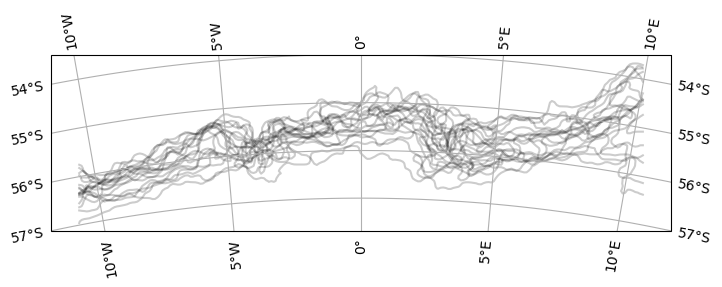

In [8]:
plt.figure(figsize=(8,6))
ax = plt.axes(projection = ccrs.SouthPolarStereo())

for (i, edge) in edge_df.iterrows():
    ax.plot(edge.lon, edge.lat,'k', alpha = 0.2, transform = ccrs.PlateCarree())
    
ax.gridlines(draw_labels = True, y_inline = False)
plt.show()

In [9]:
if save_edge:
    edge_df.to_feather(save_path  + '.feather')
    print('Saved edge as ' + save_path  + '.feather')
    
    region = pd.DataFrame({'x_min': sic.x.values[0],
                           'x_max': sic.x.values[-1], 
                           'y_min': sic.y.values[0], 
                           'y_max': sic.y.values[-1]},
                          index = [0])
    region.to_csv(save_path + '_region.csv', index = False)

Saved edge as ../processed_data/ice_edge_spring_sigma1.feather
